In [1]:
import pandas as pd
import openml
import data_preprocess as dp

data_name = 'abalone'

data = openml.datasets.get_dataset(720)

X, y, categorical_indicator, attribute_names = data.get_data(
    target=data.default_target_attribute, dataset_format="dataframe"
)

c:\users\amr20\appdata\local\programs\python\python38\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


# Data Preprocessing

In [2]:

nominal = [b for a, b in zip(categorical_indicator, attribute_names) if a]
dummied_data = pd.get_dummies(X, columns=nominal)

columns = dummied_data.columns
updates = {}
for col in columns:
    if any(x in col for x in set(('[', ']', '<', '>'))):
        updates[col] = col.replace(',', '_').replace('[', '_').replace(']', '_').replace('<', 'less').replace('>', 'greater')
dummied_data = dummied_data.rename(columns=updates)

dummied_data.fillna(0, inplace=True)
dummied_data

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_M,Sex_F,Sex_I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,1,0,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,1,0,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,0,1,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,1,0,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,0,1,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,1,0,0
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,1,0,0
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,0,1,0


In [3]:
mapping = {'P': 1, 'N': 0}

y = y.replace(mapping)

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

train_data, left_out, train_label, y_left_out = train_test_split(dummied_data, y, test_size=0.4, random_state=42)
test_data, dev_data, test_label, dev_label = train_test_split(left_out, y_left_out, test_size=0.5, random_state=42)

print(f'train shape: {train_data.shape}\n test shape: {test_data.shape}\n dev shape: {dev_data.shape}')

train shape: (2506, 10)
 test shape: (835, 10)
 dev shape: (836, 10)


In [5]:
normalized_train_data = dp.min_max_normalize(train_data, train_data)

normalized_test_data = dp.min_max_normalize(test_data, train_data)

normalized_dev_data = dp.min_max_normalize(dev_data, train_data)

In [6]:

def plot_roc(clf, X, Y):
    import matplotlib.pyplot as plt  
    from sklearn.metrics import RocCurveDisplay, roc_curve, auc
    
    RocCurveDisplay.from_estimator(clf, X, Y)
    plt.show()

In [7]:
from sklearn.utils import shuffle

#oversampled_normalized_data, oversampled_normalized_labels = dp.oversample(normalized_train_data, train_label, oversampled_class=1, num_folds=2)
#oversampled_data, oversampled_labels = dp.oversample(train_data, train_label, oversampled_class=1, num_folds=2)

normalized_train_data, normalized_train_label = shuffle(normalized_train_data, train_label, random_state=0)

# Baseline Models

## TabNet

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier()
clf.fit(
  normalized_train_data.values, normalized_train_label.values,
  eval_set=[(normalized_dev_data.values, dev_label.values)],
  patience = 20
)
preds = clf.predict(normalized_test_data.values)

tabnet_pred_prob = [i[1] for i in clf.predict_proba(normalized_test_data.values)]

roc = roc_auc_score(test_label.tolist(), tabnet_pred_prob)
prec = precision_score(test_label.tolist(), preds.tolist(), average='macro')
recall = recall_score(test_label.tolist(), preds.tolist(), average='macro')
f_score = f1_score(test_label.tolist(), preds.tolist(), average='macro')


print('roc is : {}\nprec {}\nrecall {}\nf-score {}' .format(roc, prec, recall, f_score))

c:\users\amr20\appdata\local\programs\python\python38\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79032 | val_0_auc: 0.73974 |  0:00:01s
epoch 1  | loss: 0.5729  | val_0_auc: 0.78392 |  0:00:02s
epoch 2  | loss: 0.52948 | val_0_auc: 0.76643 |  0:00:02s
epoch 3  | loss: 0.50504 | val_0_auc: 0.76712 |  0:00:02s
epoch 4  | loss: 0.48395 | val_0_auc: 0.76386 |  0:00:02s
epoch 5  | loss: 0.49059 | val_0_auc: 0.74627 |  0:00:02s
epoch 6  | loss: 0.46777 | val_0_auc: 0.72975 |  0:00:02s
epoch 7  | loss: 0.46974 | val_0_auc: 0.68017 |  0:00:02s
epoch 8  | loss: 0.47196 | val_0_auc: 0.6345  |  0:00:03s
epoch 9  | loss: 0.46459 | val_0_auc: 0.6499  |  0:00:03s
epoch 10 | loss: 0.45667 | val_0_auc: 0.62029 |  0:00:03s
epoch 11 | loss: 0.4568  | val_0_auc: 0.57882 |  0:00:03s
epoch 12 | loss: 0.44627 | val_0_auc: 0.58385 |  0:00:03s
epoch 13 | loss: 0.4466  | val_0_auc: 0.60542 |  0:00:03s
epoch 14 | loss: 0.43772 | val_0_auc: 0.67363 |  0:00:03s
epoch 15 | loss: 0.44982 | val_0_auc: 0.71101 |  0:00:03s
epoch 16 | loss: 0.45342 | val_0_auc: 0.73514 |  0:00:04s
epoch 17 | los

c:\users\amr20\appdata\local\programs\python\python38\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## MLP

Iteration 1, loss = 0.58235792
Validation score: 0.764179
Iteration 2, loss = 0.53506473
Validation score: 0.770149
Iteration 3, loss = 0.50837603
Validation score: 0.785075
Iteration 4, loss = 0.50267695
Validation score: 0.794030
Iteration 5, loss = 0.49346915
Validation score: 0.808955
Iteration 6, loss = 0.50255768
Validation score: 0.764179
Iteration 7, loss = 0.49992347
Validation score: 0.797015
Iteration 8, loss = 0.47981520
Validation score: 0.800000
Iteration 9, loss = 0.47347578
Validation score: 0.791045
Iteration 10, loss = 0.46884265
Validation score: 0.817910
Iteration 11, loss = 0.45682703
Validation score: 0.802985
Iteration 12, loss = 0.45269987
Validation score: 0.805970
Iteration 13, loss = 0.45754726
Validation score: 0.794030
Iteration 14, loss = 0.44685746
Validation score: 0.820896
Iteration 15, loss = 0.44638865
Validation score: 0.805970
Iteration 16, loss = 0.46230067
Validation score: 0.820896
Iteration 17, loss = 0.46149385
Validation score: 0.826866
Iterat

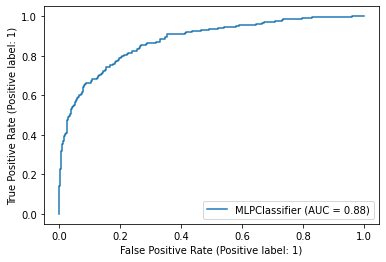

In [9]:
from sklearn.neural_network import MLPClassifier

mlp_data = pd.concat([normalized_train_data, normalized_dev_data])
mlp_labels = pd.concat([normalized_train_label, dev_label])

mlp_clf = MLPClassifier(hidden_layer_sizes=(1024,1024,), random_state=1, 
                        early_stopping=True, validation_fraction=0.1, verbose=True).fit(mlp_data, mlp_labels)

mlp_pred = mlp_clf.predict(normalized_test_data)

test_ac = mlp_clf.score(normalized_test_data, test_label)
f_score = f1_score(test_label, mlp_pred, average='macro')
prec = precision_score(test_label, mlp_pred, average='macro')
recall = recall_score(test_label, mlp_pred, average='macro')

print(f'XGB test_acc: {test_ac}\nrecall: {recall}\nprecision: {prec}\nf_score: {f_score}\n')
mlp_pred_prob = [i[1] for i in mlp_clf.predict_proba(normalized_test_data)]
roc = roc_auc_score(test_label, mlp_pred_prob)
print(f'ROC: {roc}')
plot_roc(mlp_clf, normalized_test_data, test_label)

## Random Forest

XGB test_acc: 0.7916167664670659
recall: 0.7926457564151226
precision: 0.7919908650646101
f_score: 0.7915494978479196

ROC: 0.8756052816212921


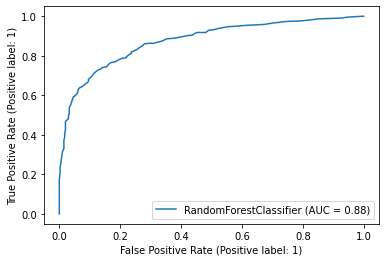

In [10]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

comb_data = pd.concat([train_data, dev_data])
comb_labels = pd.concat([train_label, dev_label])

rf_clf = RandomForestClassifier(random_state=0).fit(comb_data, comb_labels)

rf_pred = rf_clf.predict(test_data)

test_ac = rf_clf.score(test_data, test_label)
f_score = f1_score(test_label, rf_pred, average='macro')
prec = precision_score(test_label, rf_pred, average='macro')
recall = recall_score(test_label, rf_pred, average='macro')

print(f'XGB test_acc: {test_ac}\nrecall: {recall}\nprecision: {prec}\nf_score: {f_score}\n')
rf_pred_prob = [i[1] for i in rf_clf.predict_proba(test_data)]
roc = roc_auc_score(test_label, rf_pred_prob)
print(f'ROC: {roc}')
plot_roc(rf_clf, test_data, test_label)

## XGBoost

[10:10:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB test_acc: 0.7892215568862275
recall: 0.7901268647274651
precision: 0.7894477147807727
f_score: 0.7891341529207847

ROC: 0.8685288062293688


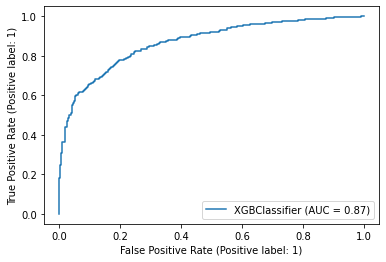

In [11]:
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

xg_boost = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)

comb_data = pd.concat([train_data, dev_data])
comb_labels = pd.concat([train_label, dev_label])

xgb_clf = xg_boost.fit(comb_data, comb_labels)
test_ac = xgb_clf.score(test_data, test_label)
pred = xgb_clf.predict(test_data)
f_score = f1_score(test_label, pred, average='macro')
prec = precision_score(test_label, pred, average='macro')
recall = recall_score(test_label, pred, average='macro')

print(f'XGB test_acc: {test_ac}\nrecall: {recall}\nprecision: {prec}\nf_score: {f_score}\n')
pred_prob = [i[1] for i in xgb_clf.predict_proba(test_data)]
roc = roc_auc_score(test_label, pred_prob)
print(f'ROC: {roc}')
plot_roc(xgb_clf, test_data, test_label)